# 1. Get features from Simulations

In [176]:
import pandas as pd
from sklearn.model_selection import train_test_split

### There must be a way to cast that in to C3 Dataset.....

In [177]:
# fetch them
parameters = c3.SimulationModelParameters.fetch().objs

# convert to JSON
parameters = parameters.toJson()

# convert to pandas df
df = pd.DataFrame(parameters)

df.sample(2)

,type,id,meta,version,ensemble,acure_bl_nuc,acure_ait_width,acure_cloud_ph,acure_carb_ff_ems,acure_carb_ff_ems_eur,...,acure_oxidants_o3,bparam,two_d_fsd_factor,c_r_correl,acure_autoconv_exp_lwp,acure_autoconv_exp_nd,dbsdtbs_turb_0,ai,m_ci,a_ent_1_rp
207,SimulationModelParameters,EnsNo_1_SimNo_87,"{'type': 'Meta', 'tenantTagId': 151, 'tenant':...",1,"{'type': 'SimulationEnsemble', 'id': '1'}",0.868470,0.188116,0.134848,1.0,0.172602,...,0.187014,0.826291,0.948661,0.280521,0.967040,0.974306,0.723699,0.895292,0.748036,0.048686
218,SimulationModelParameters,EnsNo_1_SimNo_97,"{'type': 'Meta', 'tenantTagId': 151, 'tenant':...",1,"{'type': 'SimulationEnsemble', 'id': '1'}",0.227072,0.231834,0.185796,1.0,0.997232,...,0.709293,0.204519,0.096402,0.147632,0.313749,0.741739,0.144573,0.488763,0.245905,0.686731


Columns 0 through 4 don't bring any data...

In [6]:
df.columns


Index(['type', 'id', 'meta', 'version', 'ensemble', 'acure_bl_nuc',
       'acure_ait_width', 'acure_cloud_ph', 'acure_carb_ff_ems',
       'acure_carb_ff_ems_eur', 'acure_carb_ff_ems_nam',
       'acure_carb_ff_ems_chi', 'acure_carb_ff_ems_asi',
       'acure_carb_ff_ems_mar', 'acure_carb_ff_ems_r', 'acure_carb_bb_ems',
       'acure_carb_bb_ems_sam', 'acure_carb_bb_ems_naf',
       'acure_carb_bb_ems_saf', 'acure_carb_bb_ems_bnh',
       'acure_carb_bb_ems_rnh', 'acure_carb_bb_ems_rsh', 'acure_carb_res_ems',
       'acure_carb_res_ems_chi', 'acure_carb_res_ems_asi',
       'acure_carb_res_ems_afr', 'acure_carb_res_ems_lat',
       'acure_carb_res_ems_r', 'acure_carb_ff_diam', 'acure_carb_bb_diam',
       'acure_carb_res_diam', 'acure_prim_so4_diam', 'acure_sea_spray',
       'acure_anth_so2', 'acure_anth_so2_chi', 'acure_anth_so2_asi',
       'acure_anth_so2_eur', 'acure_anth_so2_nam', 'acure_anth_so2_r',
       'acure_volc_so2', 'acure_bvoc_soa', 'acure_dms', 'acure_prim_moc',
     

In [178]:
# get the simulations ID in this order to match with target variable
simulations = pd.DataFrame(df['id'])

# get rid of some columns
X = df[df.columns[5:]]

# 2. Get target variables from Timeseries

In [180]:
# define metric
bcacc_metric = c3.SimpleMetric(id = "AverageMassBCacc_SimulationSample",
                            name = "AverageMassBCacc_SimulationSample",
                            description = "Calculates average of massBCacc for a given SimulationSample",
                            srcType = "SimulationSample",
                            path = "output",  # the timeseries is in the output field of SimSam
                            expression = "avg(avg(normalized.data.mass_BC_acc))"
                              )

In [181]:
# define metric spec
my_spec = c3.EvalMetricsSpec(
            ids = simulations['id'],
            expressions = ["AverageMassBCacc_SimulationSample"],
            start = "2017-08-19T09:00:00.000",
            end = "2017-08-19T09:00:00.000",
            interval = "SECOND" 
            )

In [182]:
# evaluate metric with spec
evalMetricsResult = c3.SimulationSample.evalMetricsWithMetadata(
                                                                spec=my_spec,
                                                                overrideMetrics=[bcacc_metric]
                                                                )

In [183]:
# transform into c3 dataset
y = c3.EvalMetricsResult.toPandas(result=evalMetricsResult)

# 3. Split dataset and create C3 Datasets

In [184]:
datasets = train_test_split(X, y, test_size=0.1, random_state=42)

In [191]:
X_train = c3.Dataset.fromPython(datasets[0])

In [192]:
X_test = c3.Dataset.fromPython(datasets[1])

In [193]:
y_train = c3.Dataset.fromPython(datasets[2])

In [194]:
y_test = c3.Dataset.fromPython(datasets[3])

# 4. Preprocess pipeline

In [195]:
# standard scaler
standardScaler = c3.SklearnPipe(
                    name="standardScaler",
                    technique=c3.SklearnTechnique(
                        # This tells ML pipeline to import sklearn.preprocessing.StandardScaler.
                        name="preprocessing.StandardScaler",
                        # This tells ML pipeline to call "transform" method on sklearn.preprocessing.StandardScaler when we invoke the C3 action process() later.
                        processingFunctionName="transform"
                    )
                 )

In [196]:
# create pre-processing pipe line (can add more steps)
preprocessPipeline = c3.MLSerialPipeline(
                        name="preprocessPipeline",
                        steps=[c3.MLStep(name="standardScaler",
                                         pipe=standardScaler),
                                ]
                     )

# 5. Regression pipelines

There are many MLScoringMetric available and you can see them with:

`c3Grid(MetadataUtil.getTypesThatMixin('MLScoringMetric', true))`

### Linear

In [198]:
linearRegression = c3.SklearnPipe(
                        name="linearRegression",
                        technique=c3.SklearnTechnique(
                            name="linear_model.LinearRegression",
                            # This tells ML pipeline to call "predict" method on sklearn.linear_model.LogisticRegression when we invoke the C3 action `process()` later.
                            processingFunctionName="predict"
                        )
                     )

In [199]:
# plug it into the pipeline
lrPipeline = c3.MLSerialPipeline(
                name="lrPipeline",
                steps=[c3.MLStep(name="preprocess",
                                 pipe=preprocessPipeline),
                       c3.MLStep(name="linearRegression",
                                 pipe=linearRegression)],
                scoringMetrics=c3.MLScoringMetric.toScoringMetricMap(scoringMetricList=[c3.MLAccuracyMetric()])
             )

### Gaussian

https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor

The `processingFunctionName` is what is called when we call the `process()` method of the pipe.

Example: Let NAME be the string in the name field. Then, transform means we should invoke/call NAME.transform(args) while predict means we should invoke/call NAME.predict(args).

In [351]:
gaussianRegression = c3.SklearnPipe(
                        name="gaussianRegression",
                        technique=c3.SklearnTechnique(
                            name="gaussian_process.GaussianProcessRegressor",
                            processingFunctionName="predict",
                            hyperParameters={
                                                'alpha': 1e-10,
                                                'copy_X_train': True,
                                                'kernel': None,
                                                'n_restarts_optimizer': 0,
                                                'normalize_y': True,
                                                'optimizer': 'fmin_l_bfgs_b',
                                                'random_state': None}
                            )
                    )

The MLScoringMetric can be either chosen from the list above or custom-created. Potential candidates:

- `MLRSquaredMetric`: Coefficient of Determination (R^2). Ratio of incorrect predictions among all the positive examples.
- `MLRootMeanSquaredErrorMetric`: Root Mean Squared Error. Heavily influenced by small number of outliers.
- `MLMeanAbsoluteErrorMetric`: Mean Absolute Error. Robust to small number of outliers.


In [377]:
grPipeline = c3.MLSerialPipeline(
                name="grPipeline",
                steps=[#c3.MLStep(name="preprocess",
                       #          pipe=preprocessPipeline),
                       c3.MLStep(name="gaussianRegression",
                                 pipe=gaussianRegression)],
                scoringMetrics=c3.MLScoringMetric.toScoringMetricMap(scoringMetricList=[c3.MLRSquaredMetric()])
             )

# 6. Train

### Linear Regression

In [200]:
trainedLr = lrPipeline.train(input=X_train, targetOutput=y_train)

In [201]:
trainedLr

c3.MLSerialPipeline(
 name='lrPipeline',
 noTrainScore=False,
 scoringMetrics=c3.Mapp<string, anyof(MLScoringMetric<any,any>)>({'MLAccuracyMetric': c3.MLAccuracyMetric()}),
 trainingScores=c3.Mapp<string, double>({'MLAccuracyMetric': 0.0}),
 untrainableOverride=False,
 trainedDate=datetime.datetime(2022, 2, 7, 21, 39, 55, tzinfo=datetime.timezone.utc),
 trainingStatus='TRAINED',
 steps=c3.Arry<MLStep>([c3.MLStep(
          name='preprocess',
          pipe=c3.MLSerialPipeline(
                 name='preprocessPipeline',
                 noTrainScore=False,
                 untrainableOverride=False,
                 steps=c3.Arry<MLStep>([c3.MLStep(
                          name='standardScaler',
                          pipe=c3.SklearnPipe(
                                 name='standardScaler',
                                 implType='SklearnPipeV7d21',
                                 noTrainScore=False,
                                 typeVersion='7.26.0',
                    

In [203]:
trainedLr.params()

c3.Mapp<string, any>({'linearRegression__coef_': c3.Arry<[double]>([c3.Arry<double>([-4.396564410528408e-12,
                              4.5153736611473905e-12,
                              2.0872484724511754e-12,
                              -17.665237278346165,
                              1.2594512978721492e-12,
                              -9.884169380933977e-13,
                              -2.4618169320491604e-12,
                              2.7415337112910526e-13,
                              -1.1487899981721603e-12,
                              7.602807272633072e-13,
                              -0.5503980976501732,
                              1.3482548411047901e-12,
                              9.969802761133906e-13,
                              7.72493180534184e-12,
                              -3.2644997816078103e-12,
                              4.640732242933154e-13,
                              2.4023005806839137e-12,
                              -0.01

### Gaussian Regression

In [378]:
trainedGr = grPipeline.train(input=X_train, targetOutput=y_train)

In [379]:
trainedGr

c3.MLSerialPipeline(
 name='grPipeline',
 noTrainScore=False,
 scoringMetrics=c3.Mapp<string, anyof(MLScoringMetric<any,any>)>({'MLRSquaredMetric': c3.MLRSquaredMetric()}),
 trainingScores=c3.Mapp<string, double>({'MLRSquaredMetric': 1.0}),
 untrainableOverride=False,
 trainedDate=datetime.datetime(2022, 2, 8, 16, 17, 55, tzinfo=datetime.timezone.utc),
 trainingStatus='TRAINED',
 steps=c3.Arry<MLStep>([c3.MLStep(
          name='gaussianRegression',
          pipe=c3.SklearnPipe(
                 name='gaussianRegression',
                 implType='SklearnPipeV7d21',
                 noTrainScore=False,
                 typeVersion='7.26.0',
                 untrainableOverride=False,
                 technique=c3.SklearnTechnique(
                             name='gaussian_process.GaussianProcessRegressor',
                             hyperParameters=c3.Mapp<string, any>({'alpha': 1e-10,
                                               'copy_X_train': True,
                          

In [323]:
trainedGr.params()

c3.Mapp<string, any>({'gaussianRegression__L_': c3.Arry<[double]>([c3.Arry<double>([1.00000000005,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                             0.0,
                 

# 7. Score

### Linear Regression

In [219]:
scoreLr = trainedLr.score(input=X_test, targetOutput=y_test)
scoreLr

c3.Mapp<string, double>({'MLAccuracyMetric': 0.0})

### Gaussian Regression

In [380]:
scoreGr = trainedGr.score(input=X_test, targetOutput=y_test)
scoreGr

c3.Mapp<string, double>({'MLRSquaredMetric': 0.08153881558842901})

# 8. Predict

### Linear Regression

In [205]:
testPrediction = trainedLr.process(input=X_test)
concatResult = c3.Dataset.concatenate(tensors=[testPrediction, y_test], dimension=1)
c3.Dataset.toPandas(dataset=concatResult)

,prediction,AverageMassBCacc_SimulationSample
132,1.506224e-10,1.443806e-10
148,1.503890e-10,1.030456e-10
93,2.306853e-11,5.534675e-11
180,2.768884e-10,2.498386e-10
15,1.607166e-10,1.282667e-10
115,1.497807e-10,1.389880e-10
172,1.341032e-10,1.609911e-10
209,7.722365e-11,1.257832e-10
75,1.849807e-10,1.572095e-10
142,2.857851e-11,1.122060e-10


### Gaussian Regression

In [364]:
testPrediction = trainedGr.process(input=X_test)
concatResult = c3.Dataset.concatenate(tensors=[testPrediction, y_test], dimension=1)
pred_df = c3.Dataset.toPandas(dataset=concatResult)

# Use Sklearn directly

In [368]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [369]:
gp = GaussianProcessRegressor(normalize_y=True)
gp.fit(datasets[0],datasets[2])

GaussianProcessRegressor(normalize_y=True)

In [370]:
gp.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [371]:
# train set
gp.score(datasets[0],datasets[2])

1.0

In [372]:
# test set
gp.score(datasets[1],datasets[3])

0.0815388155884289

### Compare SklearnPipe vs Scikit-Learn

In [373]:
pred_df['sklearn_pred'] = gp.predict(datasets[1])

<AxesSubplot:>

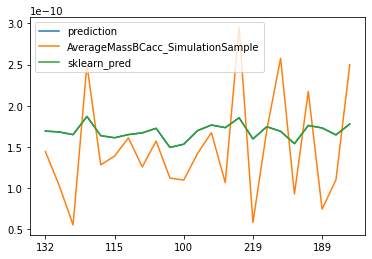

In [374]:
pred_df.plot()

In [375]:
pred_df

,prediction,AverageMassBCacc_SimulationSample,sklearn_pred
132,1.693163e-10,1.443806e-10,1.693163e-10
148,1.681847e-10,1.030456e-10,1.681847e-10
93,1.650086e-10,5.534675e-11,1.650086e-10
180,1.870974e-10,2.498386e-10,1.870974e-10
15,1.637198e-10,1.282667e-10,1.637198e-10
115,1.611912e-10,1.389880e-10,1.611912e-10
172,1.650541e-10,1.609911e-10,1.650541e-10
209,1.671112e-10,1.257832e-10,1.671112e-10
75,1.726566e-10,1.572095e-10,1.726566e-10
142,1.494646e-10,1.122060e-10,1.494646e-10
